In [1]:
library(cowplot)
library(magrittr)
library(tidyverse)
library(ggrepel)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.1
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ cowplot::ggsave()  masks ggplot2::ggsave()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


# Covariate correction

Status,age
<chr>,<dbl>
Case,50
Control,57


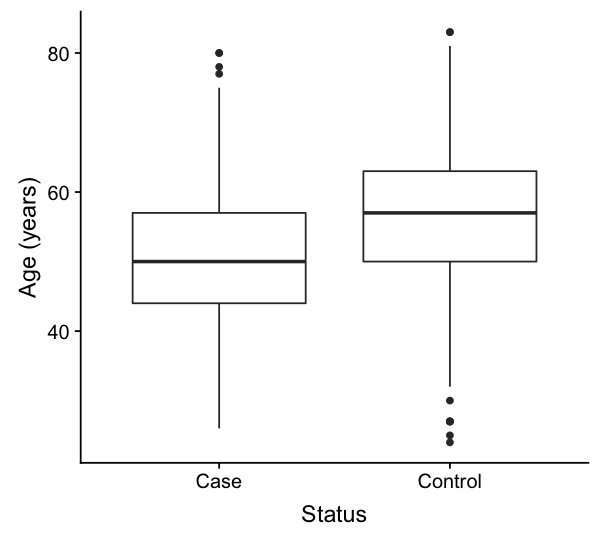

In [2]:
fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')
age <- inner_join(read_tsv('~/data/genesis/raw/CT_age_cens_tronq.cov', col_types = 'icd'), 
                  fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Status = ifelse(X6 == 1, 'Control', 'Case'))

group_by(age, Status) %>% summarize(age = median(AGE))

options(repr.plot.width=5, repr.plot.height=4.5)
ggplot(age, aes(x = Status, y = AGE)) +
    geom_boxplot() +
    labs(y = 'Age (years)')

It was surprising that controls were much older than cases: the median age among cases is 50 years, and among controls, 57. Hence, there is a strong correlation between age and case/control status. However, this 7-year difference between cases and controls is inconsistent with the study design: controls were selected to be born within ±3 years to their corresponding case, so the expected difference in years should be 0. The reason is that the variable that we are using as *age* does not mean the same between cases and controls. For cases, it is the age at diagnosis. But for controls, it is the age at interview! As the average year of diagnosis was 1998 and the study started much later, we are bound to find a strong positive correlation between being a control and being older.

This impacts the statistical test we want to perform. The way to adjust for a covariate involves fitting a logistic regression between the SNP and the covariate and the case/control status. When a covariate is associated to the outcome, it will effectively reduce the measured association between the SNPs and the phenotype. This is because the weight in the regression is split between both the SNP and the covariate. Which is desirable, when the covariate is really associated, as a fraction of the phenotype is already explained. In this case however, age is going to be associated to the outcome by design, without really providing any valuable information. Adjusting by age does not alter the ranking of association between SNPs and phenotype (the most associated SNPs are still at the top), but it severely lowers the p-values, hence reducing statistical power, making the whole distribution much more uniform.

It remains how to solve this issue with the information we have. We have two dates for both cases and controls: the date at birth and the date at the interview. Then, for the cases, we have the year of diagnosis, which we can use to compute the age at moment.
- Age at diagnosis of the corresponding case: we cannot compute it, since we do not know the case-control matching.
- Age at interview/year of birth: doable if we know that controls did not develop a cancer. But, if that is the case, what for? Our ideal controls would be those that we know at sample collection that 1) share generation with the cases (proxy for lifestyle & environment); and 2) have not and will never develop cancer. Hence, if our controls are still cancer-free at interview time, they are even better controls...
- Do nothing: by design, the experiment controls by age, and hence it should have minimal effects on the outcome.

## Gene-level analyses

### All SNPs vs. LD pruned

In [3]:
vegas <- inner_join(read_tsv('scored_genes.vegas.pruned.txt', col_types = 'icidiidddcd'), 
                    read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'icidiidddcd'), 
                    by = c('Chr','Gene','Start','Stop'), suffix = c('_pruned', '_full'))

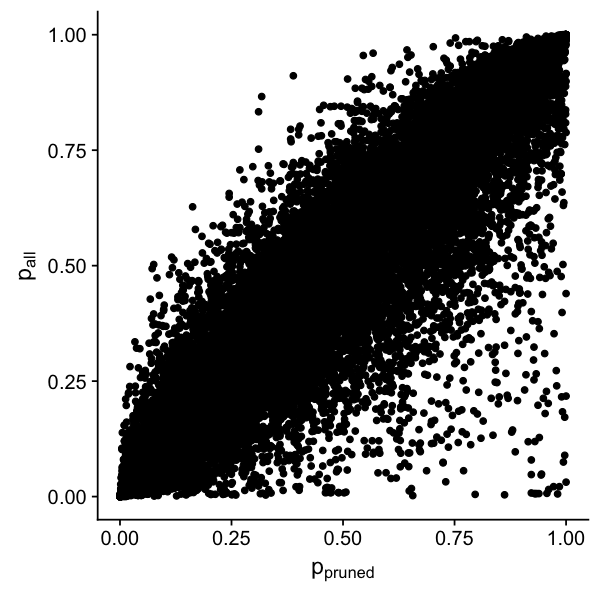

In [4]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(vegas, aes(Pvalue_pruned, Pvalue_full)) +
    geom_point() +
    labs(x = bquote('p' [pruned]), y = bquote('p' [all]))

Conclusion: we should not LD prune our data for VEGAS-score computation.

### All SNPs: age adjustment vs. no correction

In [5]:
vegas <- inner_join(read_tsv('scored_genes.vegas.age_adjust.txt', col_types = 'icidiidddcd'), 
                    read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'icidiidddcd'), 
                    by = c('Chr','Gene','Start','Stop'), suffix = c('_covars', '_no_covars')) %>%
    arrange(Pvalue_covars) %>%
    mutate(., q_covars = seq(1, nrow(.))/nrow(.)) %>%
    arrange(Pvalue_no_covars) %>%
    mutate(., q_no_covars = seq(1, nrow(.))/nrow(.))

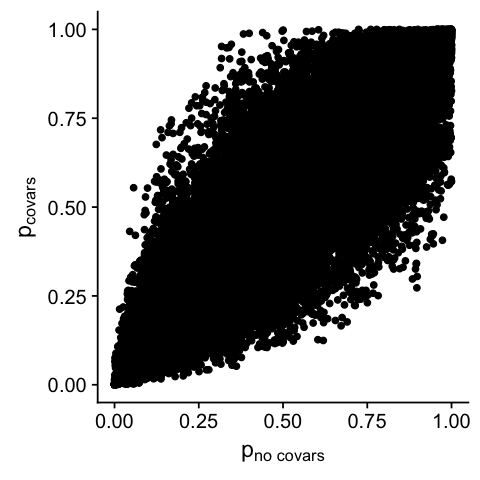

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(vegas, aes(Pvalue_no_covars, Pvalue_covars)) +
    geom_point() +
    labs(x = bquote('p' ['no covars']), y = bquote('p' ['covars']))

Warning message:
“Removed 1 rows containing missing values (geom_point).”

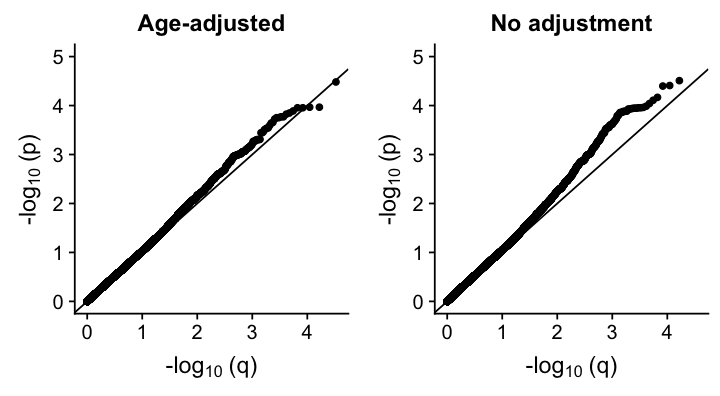

In [7]:
no_covars <- ggplot(vegas, aes(-log10(q_no_covars), -log10(Pvalue_no_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'No adjustment', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)')) +
    scale_y_continuous(limits = c(0, 5))

covars <- ggplot(vegas, aes(-log10(q_covars), -log10(Pvalue_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'Age-adjusted', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)')) +
    scale_y_continuous(limits = c(0, 5))

options(repr.plot.width=6, repr.plot.height=3.3)
plot_grid(covars, no_covars)

### Genes: all SNPs vs top x%

Joining, by = c("Chr", "Gene", "nSNPs", "nSims", "Start", "Stop", "Best-SNP", "SNP-pvalue")
Joining, by = c("Chr", "Gene", "nSNPs", "nSims", "Start", "Stop", "Best-SNP", "SNP-pvalue")
Joining, by = c("Chr", "Gene", "nSNPs", "nSims", "Start", "Stop", "Best-SNP", "SNP-pvalue")


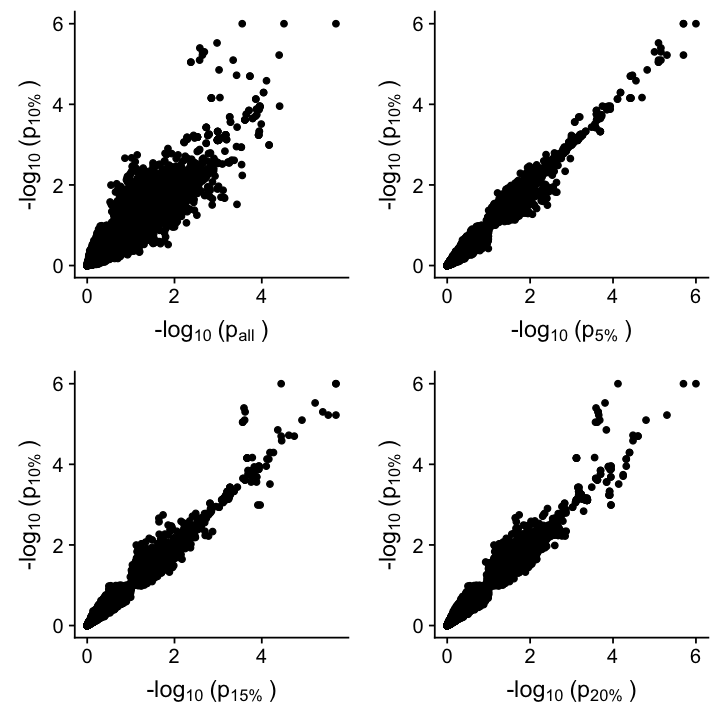

In [8]:
tops <- inner_join(read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd'),
                    read_tsv('../conventional_gwas/vegas_5p/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>% select(-Test, -Pvalue)) %>%
         inner_join(read_tsv('../conventional_gwas/vegas_15p/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>% select(-Test, -Pvalue)) %>%
         inner_join(read_tsv('../conventional_gwas/vegas_20p/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>% select(-Test, -Pvalue))

top5 <- ggplot(tops, aes(-log10(`Top-0.05-pvalue`), -log10(`Top-0.1-pvalue`))) +
    geom_point() +
    labs(x = bquote('-log'[10]~'(p'['5%']~')'), y = bquote('-log'[10]~'(p'['10%']~')'))

top15 <- ggplot(tops, aes(-log10(`Top-0.15-pvalue`), -log10(`Top-0.1-pvalue`))) +
    geom_point() +
    labs(x = bquote('-log'[10]~'(p'['15%']~')'), y = bquote('-log'[10]~'(p'['10%']~')'))

top20 <- ggplot(tops, aes(-log10(`Top-0.2-pvalue`), -log10(`Top-0.1-pvalue`))) +
    geom_point() +
    labs(x = bquote('-log'[10]~'(p'['20%']~')'), y = bquote('-log'[10]~'(p'['10%']~')'))

all <- ggplot(tops, aes(-log10(`Pvalue`), -log10(`Top-0.1-pvalue`))) +
    geom_point() +
    labs(x = bquote('-log'[10]~'(p'[all]~')'), y = bquote('-log'[10]~'(p'['10%']~')'))

options(repr.plot.width=6, repr.plot.height=6)
plot_grid(all, top5, top15, top20)

## SNP-level analyses

### Adjusting vs. not adjusting

In [9]:
snps <- inner_join(read_tsv('univariate_models.covars.tsv', col_types = 'icdccdddd') %>% filter(TEST == 'ADD'), 
                   read_tsv('univariate_models.no_covars.tsv', col_types = 'icdccccddd'),
                   by = c('CHR', 'SNP', 'BP', 'A1'), suffix = c('_covars', '_no_covars')) %>%
    arrange(P_covars) %>%
    mutate(., q_covars = seq(1, nrow(.))/nrow(.)) %>%
    arrange(P_no_covars) %>%
    mutate(., q_no_covars = seq(1, nrow(.))/nrow(.))

Warning message:
“Removed 8 rows containing missing values (geom_point).”

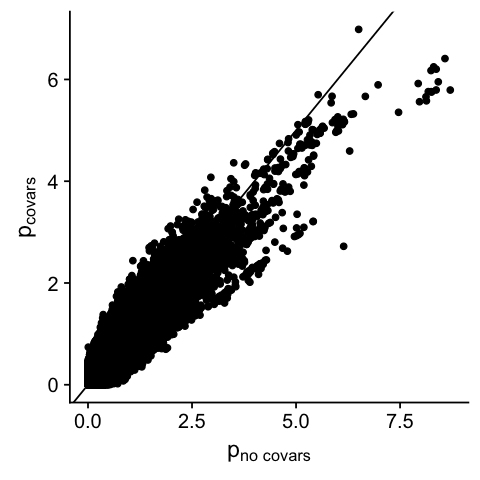

In [10]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(snps, aes(-log10(P_no_covars), -log10(P_covars))) +
    geom_point() +
    geom_abline(slope = 1) +
    labs(x = bquote('p' ['no covars']), y = bquote('p' ['covars']))

Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 12 rows containing missing values (geom_point).”

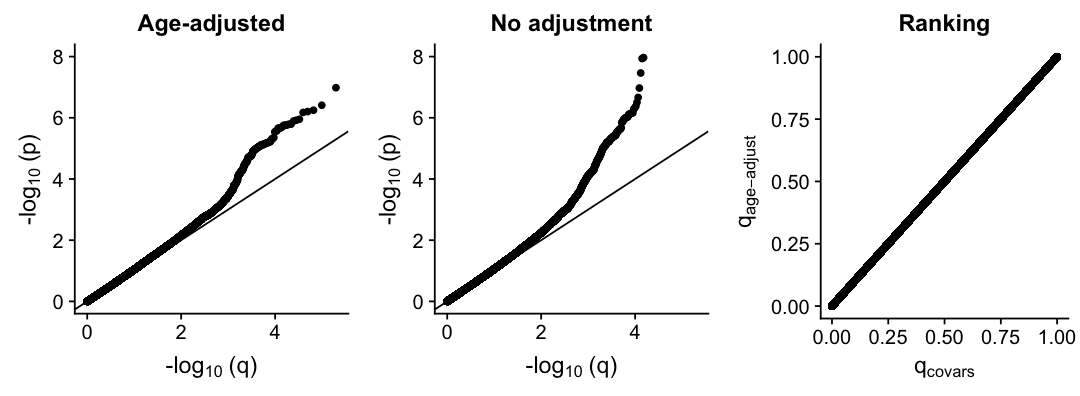

In [11]:
no_covars <- ggplot(snps, aes(-log10(q_no_covars), -log10(P_no_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'No adjustment', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)')) +
    scale_y_continuous(limits = c(0, 8))

covars <- ggplot(snps, aes(-log10(q_covars), -log10(P_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'Age-adjusted', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)')) +
    scale_y_continuous(limits = c(0, 8))

ranking <- ggplot(snps, aes(q_covars, q_covars)) +
    geom_point() + 
    labs(title = 'Ranking', x = bquote('q'[covars]), y = bquote('q'[age-adjust]))

options(repr.plot.width=9, repr.plot.height=3.3)
plot_grid(covars, no_covars, ranking, ncol = 3, rel_widths = c(1,1,1))

In [12]:
sum(snps$P_no_covars < (0.05/nrow(snps)))

[1] 17

In [13]:
sum(snps$P_covars < (0.05/nrow(snps)), na.rm = T)

[1] 1

### Chi2 vs logistic

In [14]:
snps <- inner_join(read_tsv('univariate_models.no_covars.logistic.tsv', col_types = 'icdccdddd') %>% filter(TEST == 'ADD'), 
                   read_tsv('univariate_models.no_covars.tsv', col_types = 'icdccccddd'),
                   by = c('CHR', 'SNP', 'BP', 'A1'), suffix = c('_logistic', '_chi2')) %>%
    arrange(P_logistic) %>%
    mutate(q_logistic = seq(1, n())/n()) %>%
    arrange(P_chi2) %>%
    mutate(q_chi2 = seq(1, n())/n())

Warning message:
“Removed 8 rows containing missing values (geom_point).”

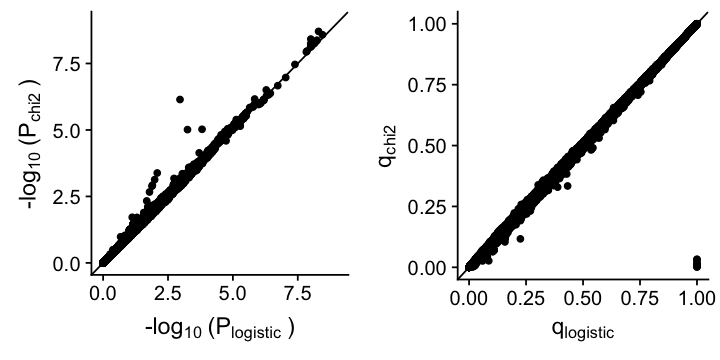

In [15]:
options(repr.plot.width=4, repr.plot.height=4)
pvals <- ggplot(snps, aes(-log10(P_logistic), -log10(P_chi2))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(x = bquote('-log' [10] ~'(P'[logistic]~')'), y = bquote('-log' [10] ~'(P'[chi2]~')')) +
    scale_x_continuous(limits = c(0, 9)) +
    scale_y_continuous(limits = c(0, 9))

ranking <- ggplot(snps, aes(q_logistic, q_chi2)) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(x = bquote('q'[logistic]), y = bquote('q'[chi2]))

options(repr.plot.width=6, repr.plot.height=3)
plot_grid(pvals, ranking)

# GWAS

## SNP

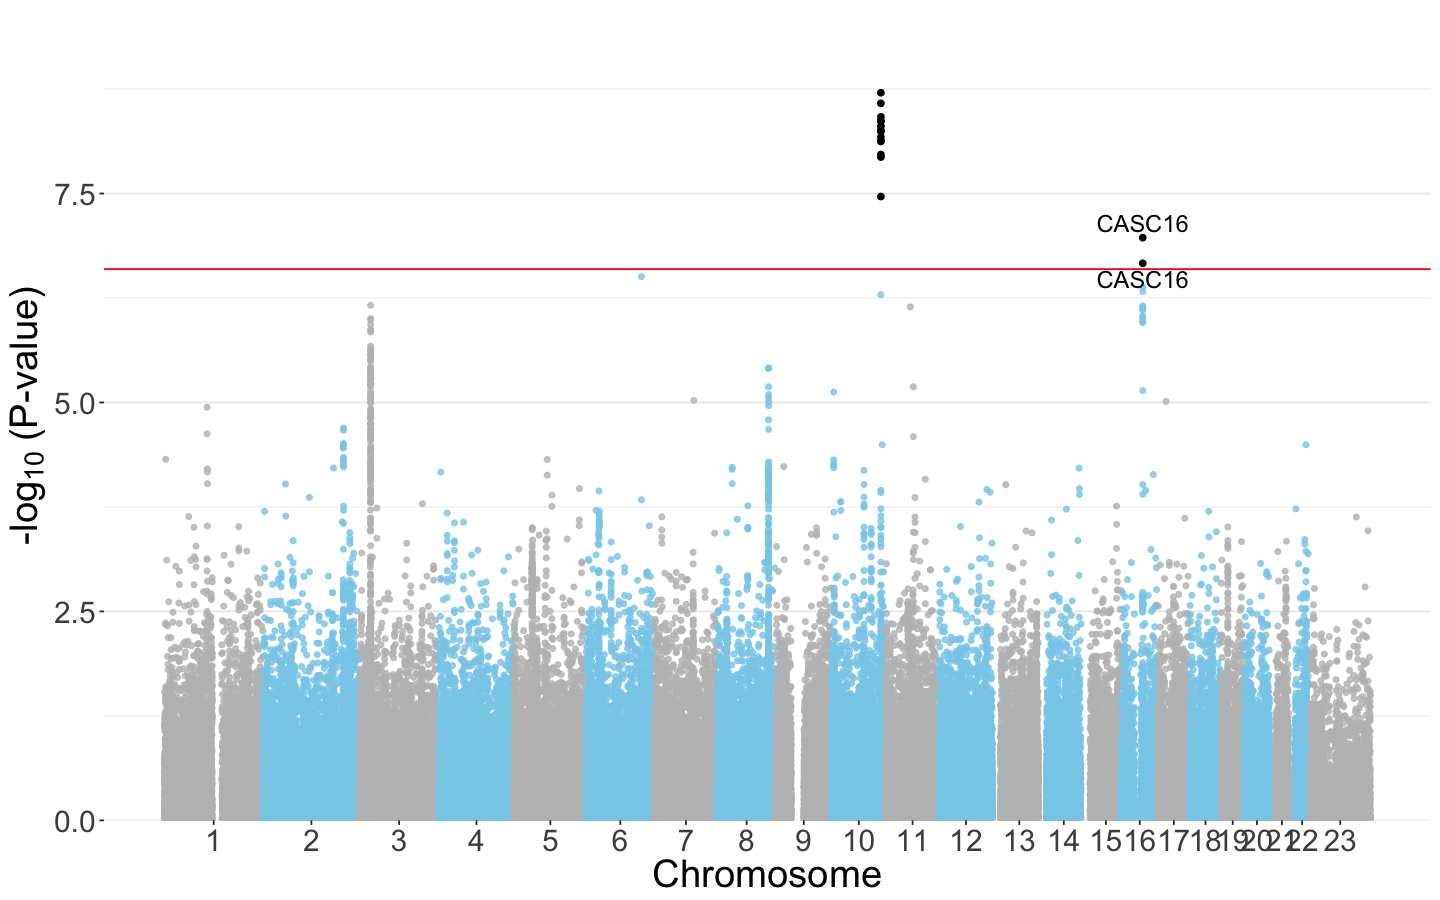

In [16]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv('../preprocessing/snp2hgnc.tsv', col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv('univariate_models.no_covars.tsv', col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(gene)), 
                    aes(x=BPcum, y=-log10(P), label = gene), size = 5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 23),
      axis.text = element_text(size = 18),
      strip.text.y = element_text(size = 15),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

## Gene

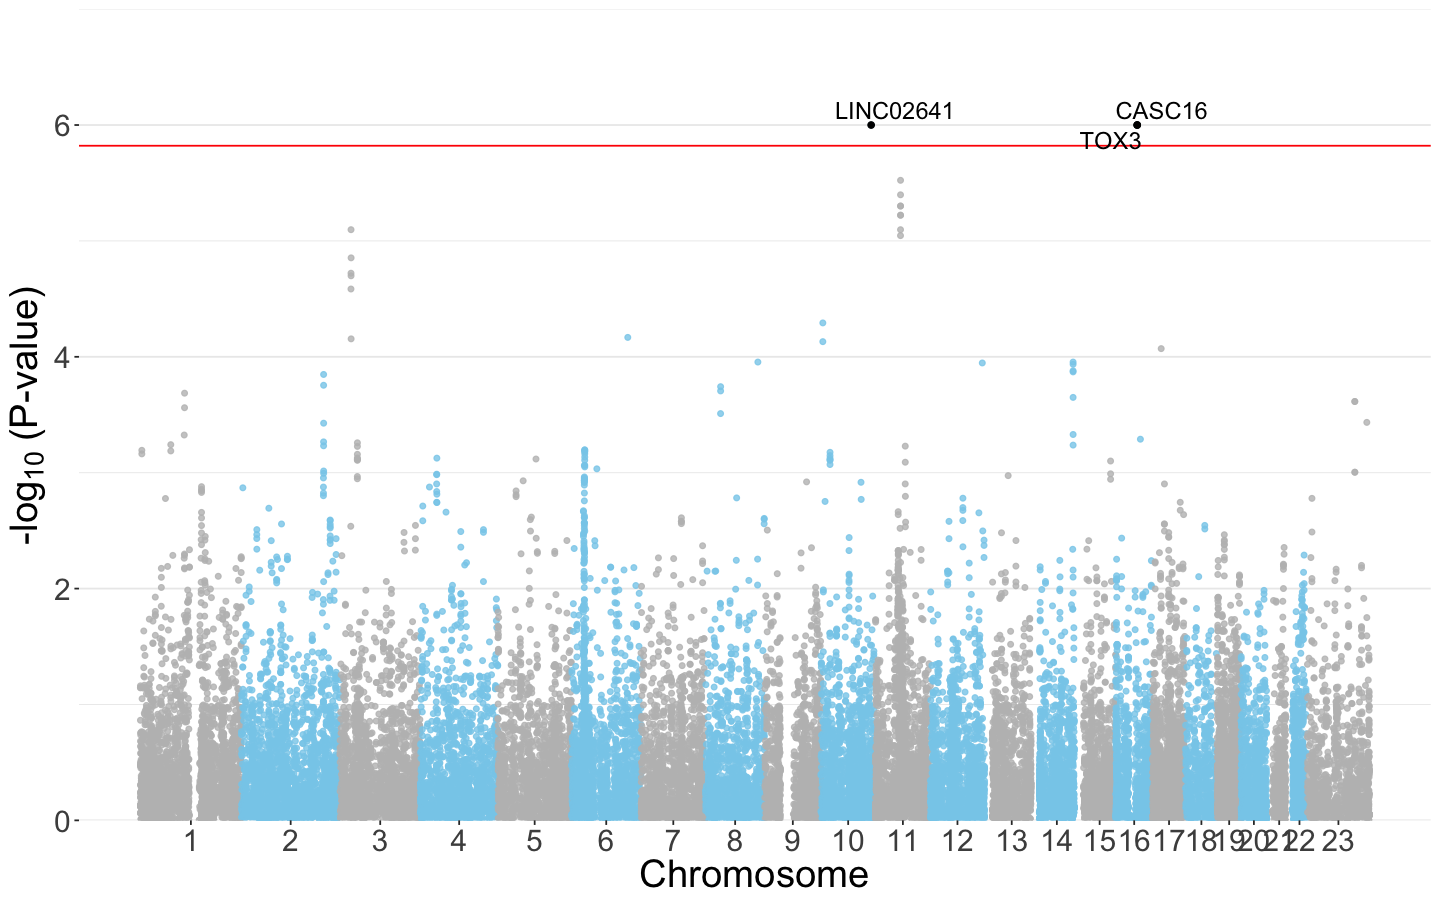

In [17]:
gwas <- read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
                    aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), size = 5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 23),
      axis.text = element_text(size = 18),
      strip.text.y = element_text(size = 15),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

# QC

In [18]:
evs <- read_tsv('genesis_2019.eigenvec')

Parsed with column specification:
cols(
  .default = col_double(),
  IID = col_character()
)
See spec(...) for full column specifications.


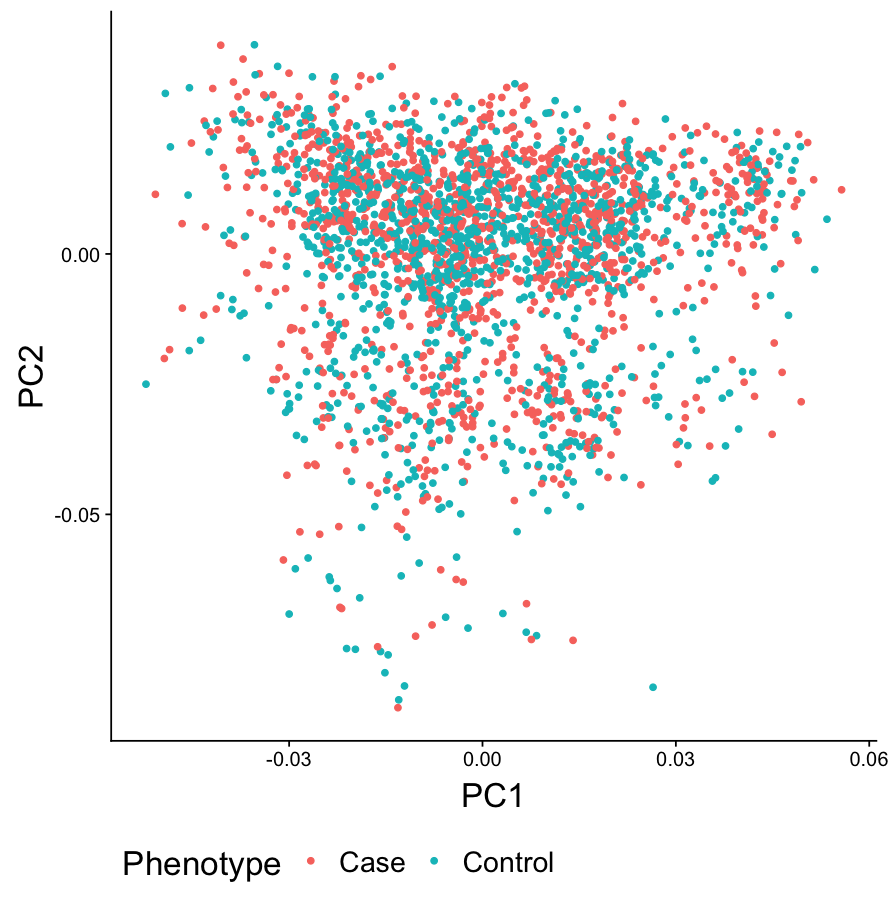

In [19]:
options(repr.plot.width=7.4, repr.plot.height=7.5)
inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC1, PC2, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'bottom', 
              text = element_text(size = 20))